# Imports

In [175]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns
import pickle

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# from sklearn.manifold import TSNE
# from sklearn.decomposition import TruncatedSVD

# Data

In [2]:
april = pd.read_csv('april2017listings.csv')
april= april.dropna(subset=['neighborhood_overview'])
april = april.reset_index(drop=True)

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [161]:
pickle.dump(april, open("april.p", "wb"))

# Preprocessing

## Tokenize

In [3]:
stopword = stopwords.words('english')
stopword += list(string.punctuation)
stopword += ['``', '\'\'', '–']
stopword += ['distance', 'angeles', 'block', 'away', 'great', 'mile', 'park street',
             'la live', 'street park', 'hill west', 'place', 'perfect', 'area',
             'neighborhood la', 'close', 'california', 'step','la',
             'ride', 'right', 'url', 'place walk', 'car', 'city los']
drop_patterns = ['[0-9_]', 'locat', 'min', 'neighbor']

In [4]:
token_list = []
for row in april['neighborhood_overview']:
    row = row.lower()
    words = nltk.sent_tokenize(row)
    places = []
    for word in words: 
        tokens = WordPunctTokenizer().tokenize(word)
        for i, token in enumerate(tokens):
            if token in stopword:
                del tokens[i]
        for s in drop_patterns: #
            drop_pattern = re.compile(s, re.I)    #    
            tokens = [w for w in tokens if not drop_pattern.search(w)] #
        places.extend(tokens)
    token_list.append(places)

## Lemmatize

In [5]:
lemmatizer = WordNetLemmatizer()
lemma_pos = {'JJ': 'a',
             'NN': 'n',
             'RB': 'r', 
             'VB': 'v'}

In [6]:
nho_lemmas = []
for row in token_list:
    lemmas = []
    pos_tags = pos_tag(row)
    for word, pos in pos_tags:
        if pos != 'NNP' and pos != 'NNPS':
            try:
                p = lemma_pos[pos[:2]]
                lemma = lemmatizer.lemmatize(word, pos=p)
                if lemma not in stopword:
                    lemmas.append(lemma)
            except:
                pass
    nho_lemmas.append(' '.join(lemmas))

# Vectorize

In [7]:
vec = TfidfVectorizer(ngram_range=(2, 2), 
                      stop_words='english', 
                      token_pattern="\\b[a-z][a-z]+\\b", 
                      min_df=100)
tfidf = vec.fit_transform(nho_lemmas)
tfidf_features = vec.get_feature_names()

In [8]:
top = vec.idf_.argsort()[0:30].tolist()
[(tfidf_features[i], vec.idf_[i]) for i in top]

[('santa monica', 2.8353567179339887),
 ('beverly hill', 3.377163653391746),
 ('farmer market', 3.515649639140952),
 ('grocery store', 3.5222941818596207),
 ('coffee shop', 3.7406871304152327),
 ('restaurant bar', 3.7658834243341199),
 ('venice beach', 3.7683165155587615),
 ('west hollywood', 3.7707555411581204),
 ('universal studio', 3.8627744398783723),
 ('shop restaurant', 3.9149840984790623),
 ('easy access', 3.9790525843553355),
 ('walk fame', 4.0588446968640479),
 ('griffith park', 4.1004134413596027),
 ('restaurant shop', 4.1367182062900385),
 ('hollywood walk', 4.2483581774327082),
 ('echo park', 4.2763041078232673),
 ('movie theater', 4.3411125709249561),
 ('los feliz', 4.3785206729911259),
 ('culver city', 4.4173827060831723),
 ('silver lake', 4.4173827060831723),
 ('bar restaurant', 4.4481543647499269),
 ('abbot kinney', 4.4626824653128363),
 ('staple center', 4.4873750779032076),
 ('downtown los', 4.5334190164046149),
 ('short walk', 4.5386683722907577),
 ('sunset strip', 4

In [9]:
bottom = vec.idf_.argsort()[::-1].tolist()[0:30]
[(tfidf_features[i], vec.idf_[i]) for i in bottom]

[('hermosa beach', 5.8637191081699305),
 ('ton restaurant', 5.8538668117269186),
 ('people walk', 5.8538668117269186),
 ('bar walk', 5.8538668117269186),
 ('muscle beach', 5.8441106367815543),
 ('ice cream', 5.8441106367815543),
 ('small town', 5.8441106367815543),
 ('noho art', 5.8344487258698168),
 ('quiet friendly', 5.8248792748536662),
 ('elysian park', 5.8248792748536662),
 ('drive santa', 5.8248792748536662),
 ('mar vista', 5.8248792748536662),
 ('bus line', 5.8154005308991223),
 ('coffee house', 5.8060107905492835),
 ('restaurant grocery', 5.8060107905492835),
 ('walk dog', 5.7967083978869702),
 ('shopping restaurant', 5.7874917427820458),
 ('drive downtown', 5.7783592592187736),
 ('walk best', 5.7783592592187736),
 ('cafe restaurant', 5.7693094236988554),
 ('family friendly', 5.7514518062988493),
 ('fast food', 5.7514518062988493),
 ('city los', 5.7514518062988493),
 ('redondo beach', 5.7426411766166945),
 ('park hike', 5.7252494339048248),
 ('larchmont village', 5.725249433904

## Filter out listings without stop words

In [10]:
tfidf_df = pd.DataFrame(tfidf.toarray(),columns=tfidf_features)
tfidf_df['total'] = tfidf_df[tfidf_features].sum(axis=1)
tfidf_df['overview'] = april['neighborhood_overview']
tfidf_df = tfidf_df.loc[tfidf_df['total'] != 0]
tfidf_df = tfidf_df.reset_index(drop=True)

In [13]:
corpus = tfidf_df.iloc[:, :-2]

In [173]:
pickle.dump(corpus, open("corpus.p", "wb"))

# Dimension Reduction
At the moment, each bigram is its own dimensions. As dimensions reduce, related bigrams group together, and appear more and more like interpretable topics.   
8 dimensions is the most interpretable.

In [14]:
nmf = NMF(n_components=8, #this is dimensions
          init='nndsvd',
          solver = 'cd')
nmf_topic = nmf.fit_transform(corpus)

In [15]:
nho_df = pd.DataFrame(nmf_topic)
nho_df.columns = ['topic_' + str(col) for col in nmf_df.columns]
nho_df['overview'] = tfidf_df['overview']
nho_df = nho_df.reset_index(drop=True)

In [18]:
def display_topics(model, features, n):
    for index, topic in enumerate(model.components_):
        print("\n" + 'TOPIC %d:' % index)
        print('TOP %d WORDS:' % n)
        for i in topic.argsort()[:-n - 1:-1]:
            print(features[i])
        print('EXAMPLE LISTING:')
        print(nho_df.ix[nho_df['topic_%d' % index].idxmax()]['overview'])

In [19]:
best_nho = display_topics(nmf, vec.get_feature_names(), 10)


TOPIC 0:
TOP 10 WORDS:
santa monica
venice beach
monica pier
del rey
monica beach
abbot kinney
monica venice
marina del
main street
beach santa
EXAMPLE LISTING:
Brentwood is one of th best neighborhoods in LA. It is right on the edge of the Santa Monica mountains. Amazing hiking and surfing are minutes away. On our street and in our neighborhood are large family homes. We are the only block of condos in our area.

TOPIC 1:
TOP 10 WORDS:
grocery store
movie theater
walk grocery
restaurant grocery
staple center
convention center
store restaurant
store walk
trader joe
coffee shop
EXAMPLE LISTING:
Close to all the major studios. We're also minutes away from major dance studios as well as rehearsal studios for musicians. If you're in town for a gig or audition, our place is close to all of it making your drive time one less thing to worry about. Our spot is within walking distance of Steampunk cafe & Harvest Moon café, Bar One beer and wine parlor, Le Sushi restaurant, El Pollo Loco, Cambr

# Cluster

## Silhouette Scores
Investigating different cluster methods & number of clusters.

### KMeans Scores

In [117]:
def score_this(num, df): 
    nmf = NMF(n_components=num, #this is dimensions
          init='nndsvd',
          solver = 'cd',
#           random_state=16
         )
    data = nmf.fit_transform(df)
  
    X = data
    range_n_clusters = range(5, 20)    
    
    for n_clusters in range_n_clusters:
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10  

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([]) 
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

For n_clusters = 5 The average silhouette_score is : 0.369637053284
For n_clusters = 6 The average silhouette_score is : 0.376219197421
For n_clusters = 7 The average silhouette_score is : 0.397295094901
For n_clusters = 8 The average silhouette_score is : 0.418816562319
For n_clusters = 9 The average silhouette_score is : 0.411363975305
For n_clusters = 10 The average silhouette_score is : 0.41478565295
For n_clusters = 11 The average silhouette_score is : 0.409628520291
For n_clusters = 12 The average silhouette_score is : 0.40498010728
For n_clusters = 13 The average silhouette_score is : 0.400804174805
For n_clusters = 14 The average silhouette_score is : 0.376152072656
For n_clusters = 15 The average silhouette_score is : 0.371262917073
For n_clusters = 16 The average silhouette_score is : 0.366942748164
For n_clusters = 17 The average silhouette_score is : 0.338496606083
For n_clusters = 18 The average silhouette_score is : 0.335286687851
For n_clusters = 19 The average silhouett

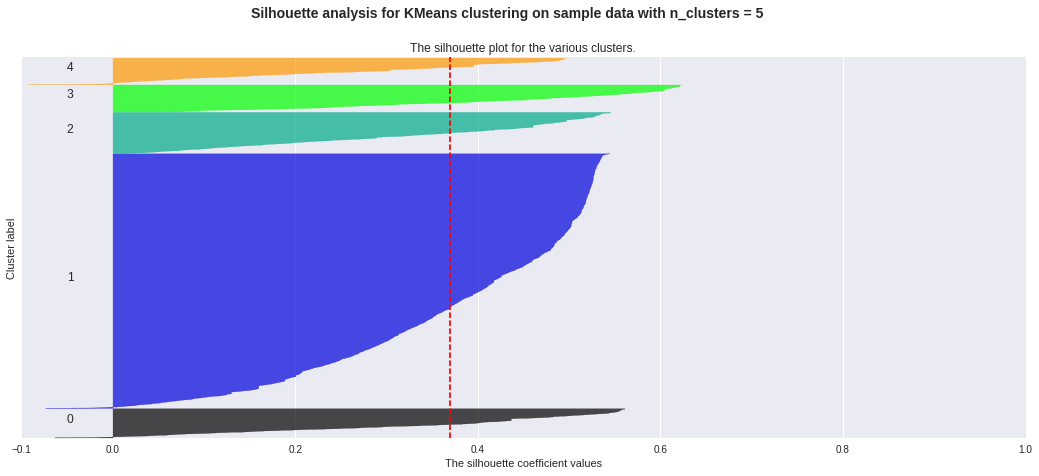

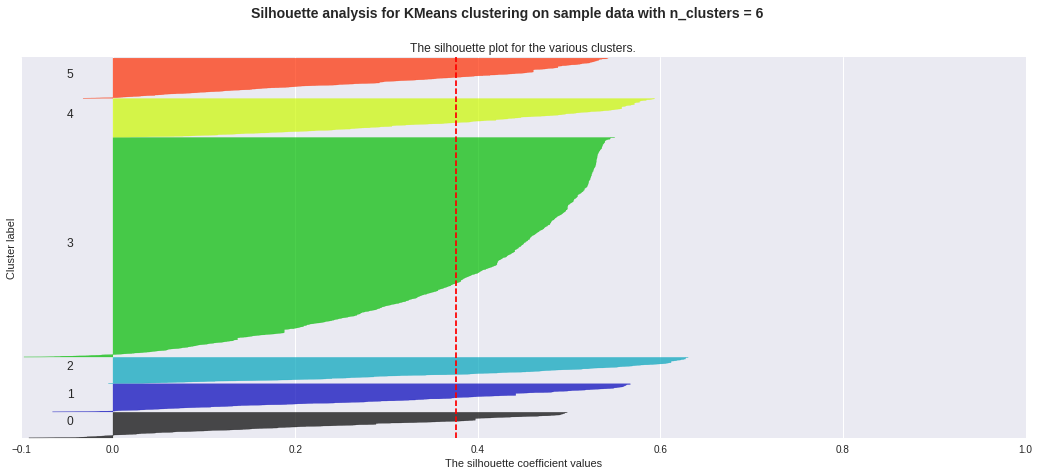

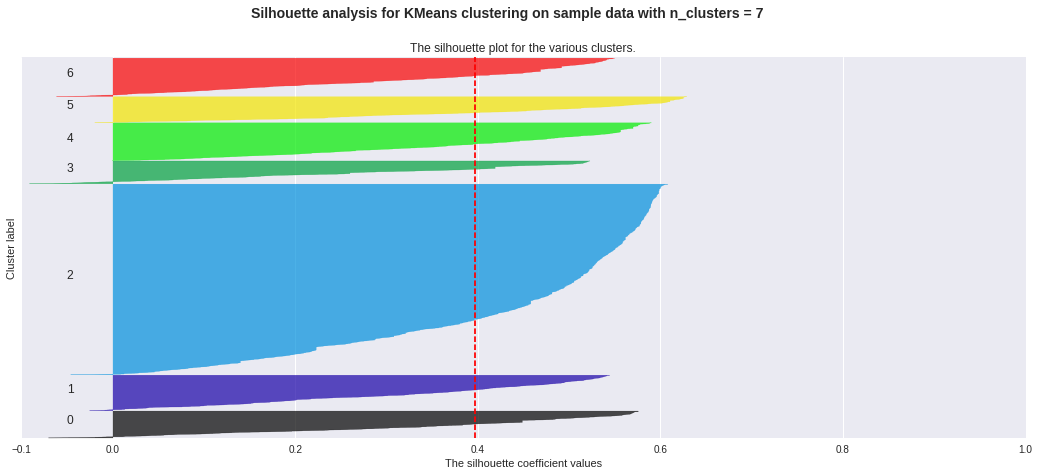

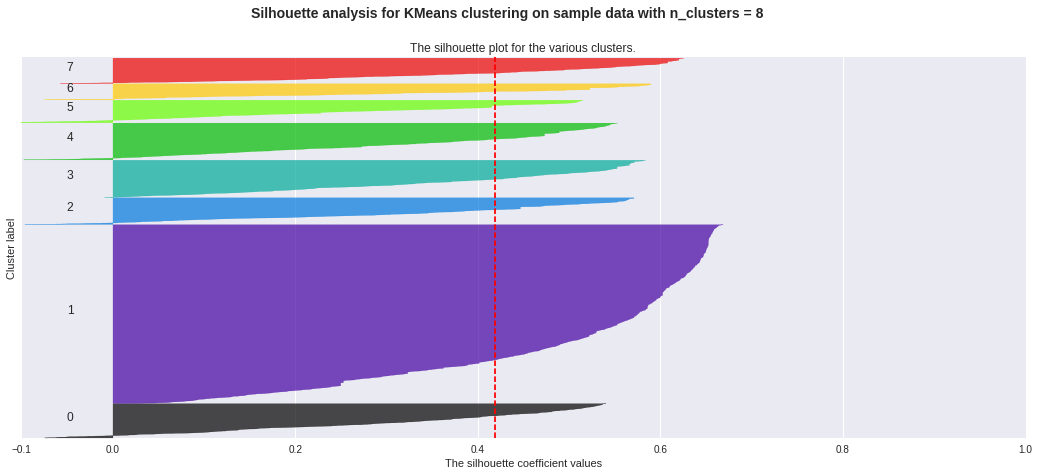

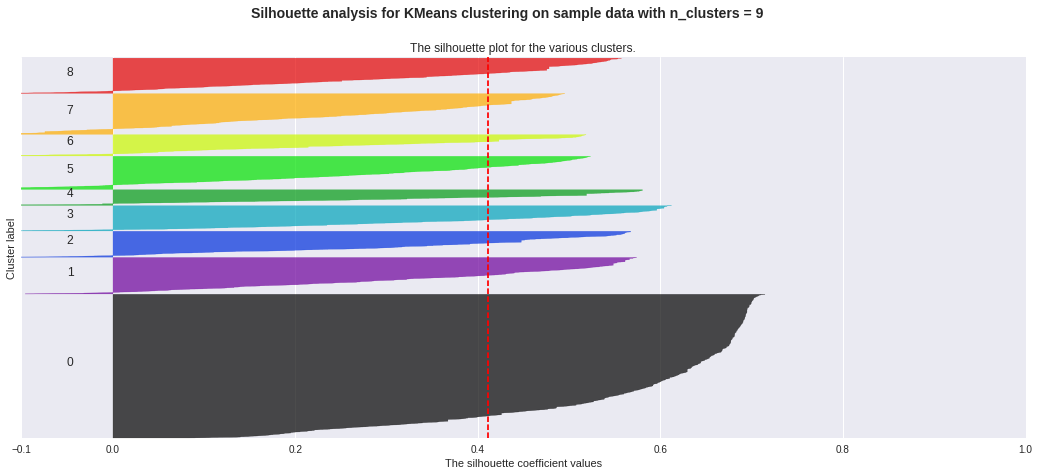

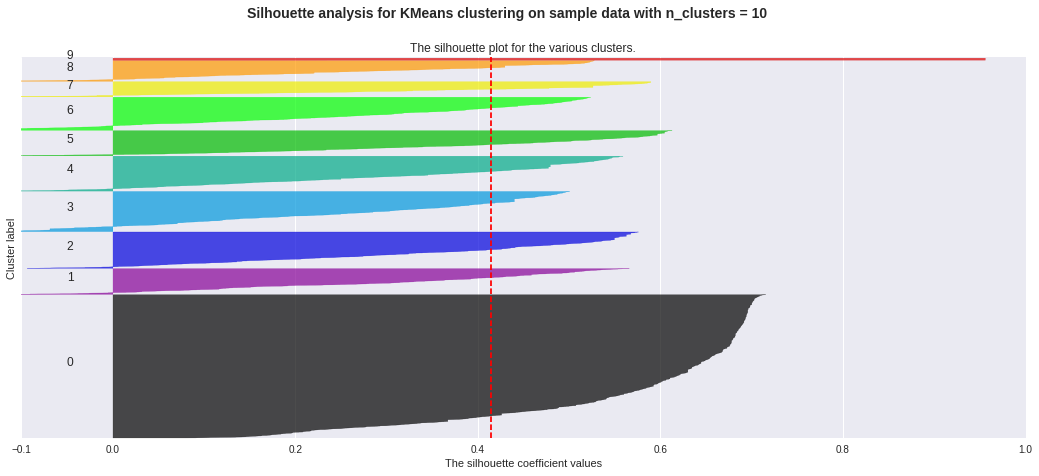

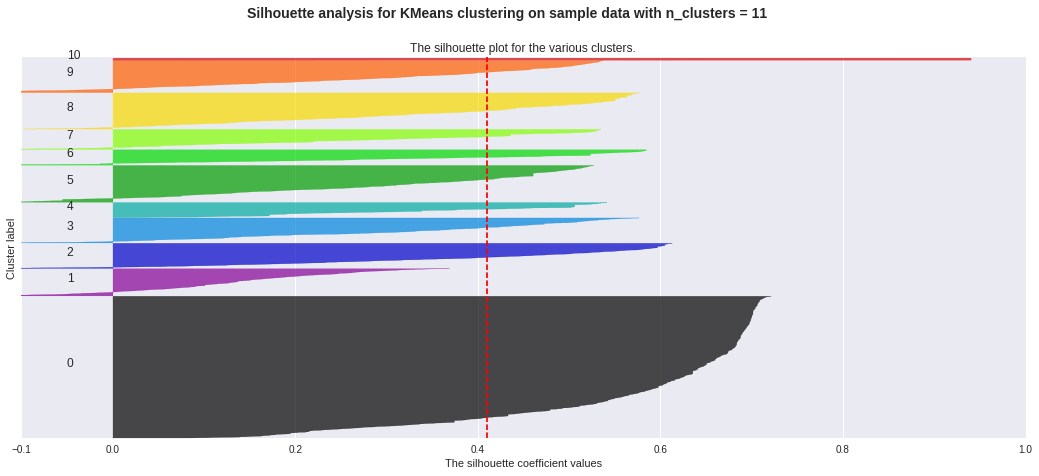

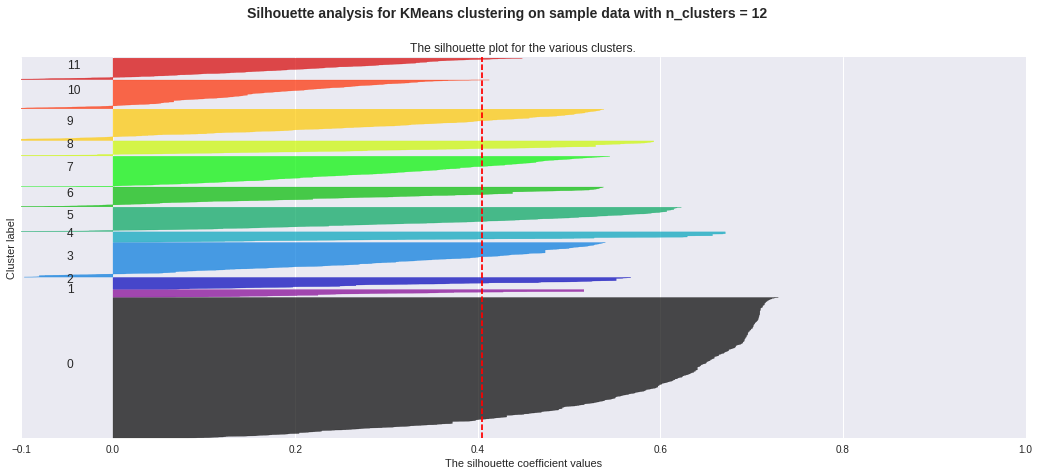

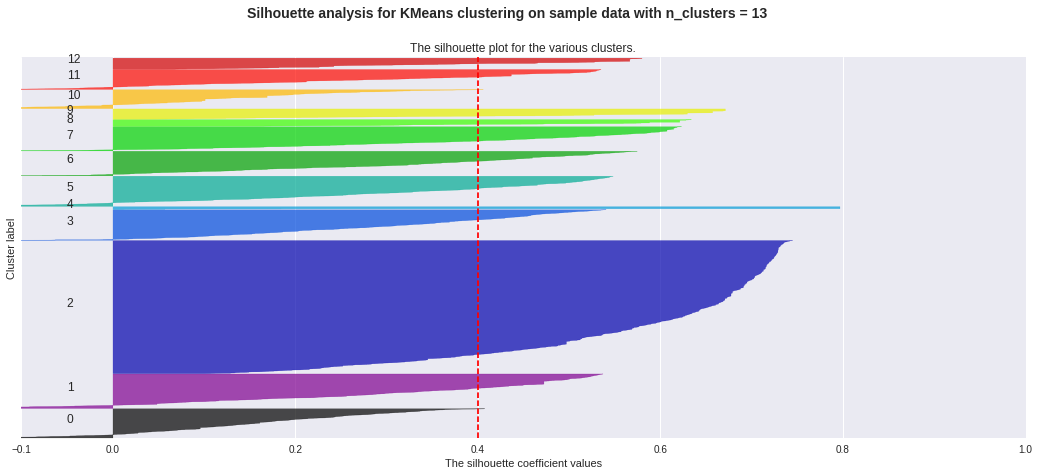

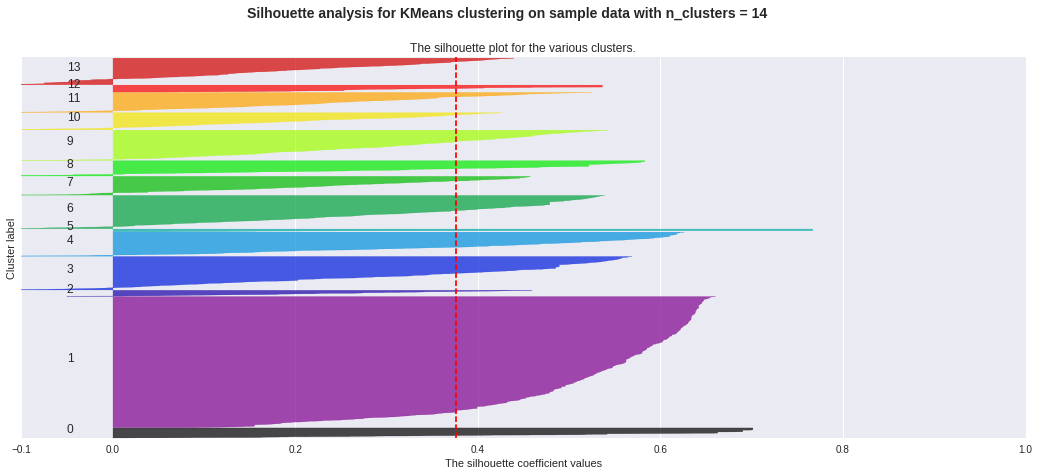

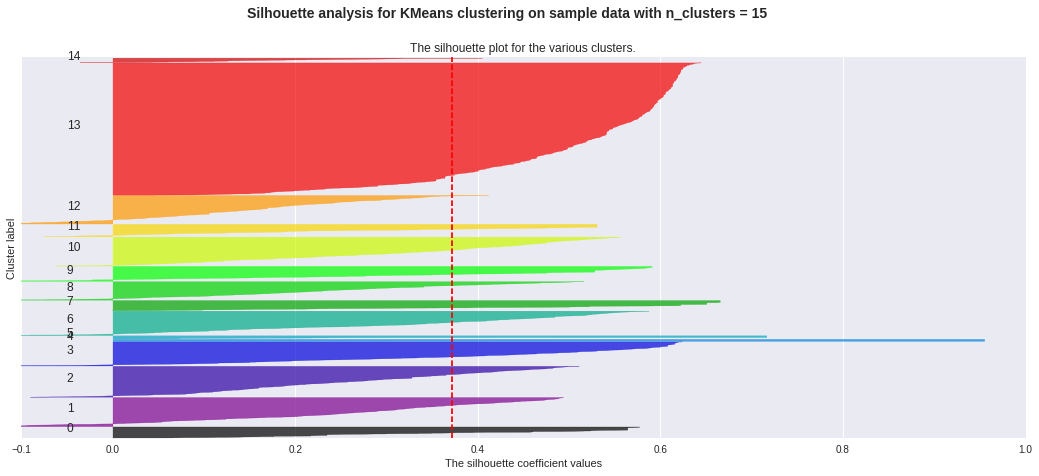

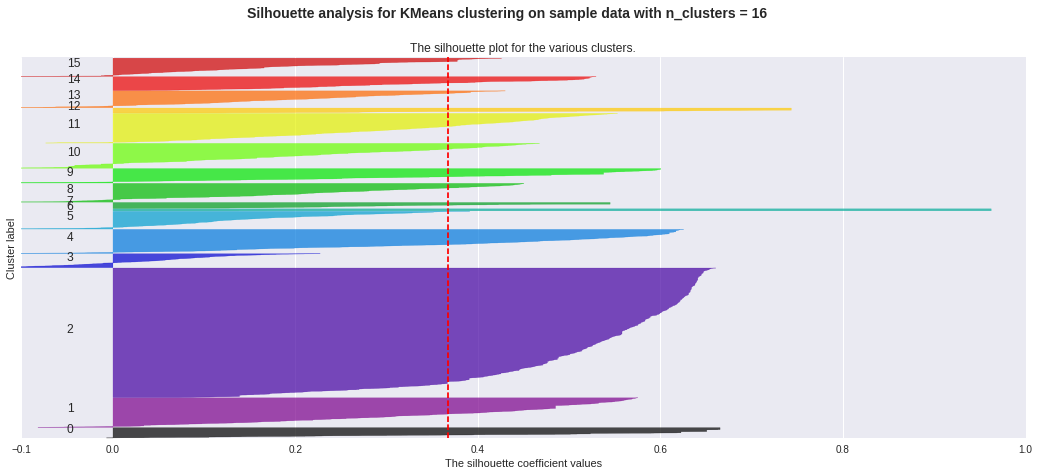

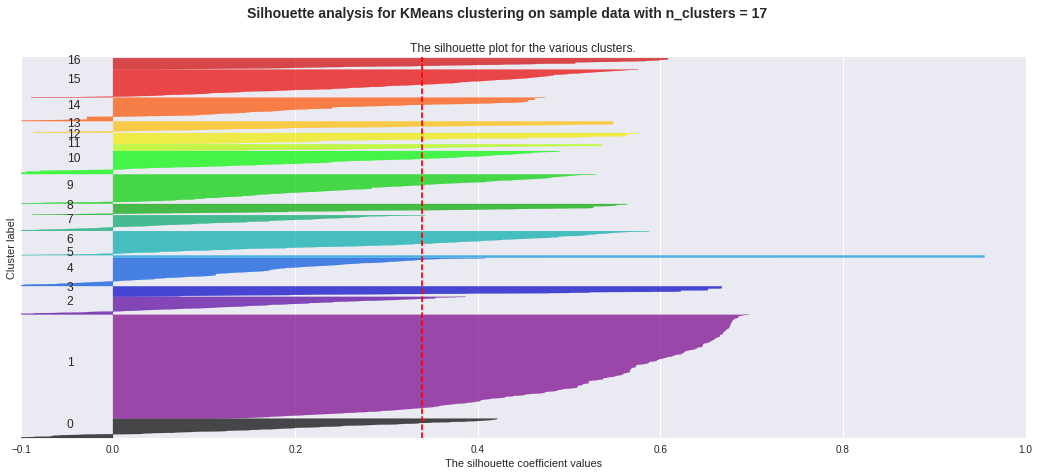

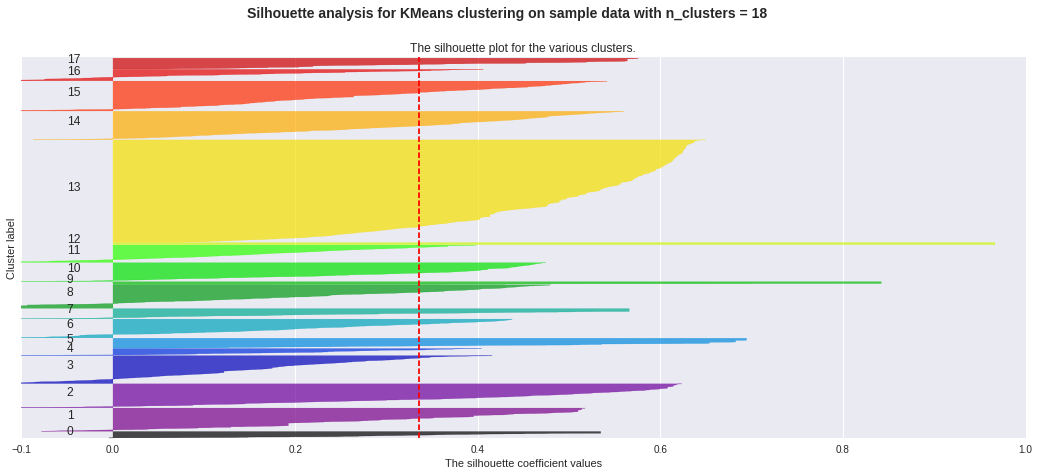

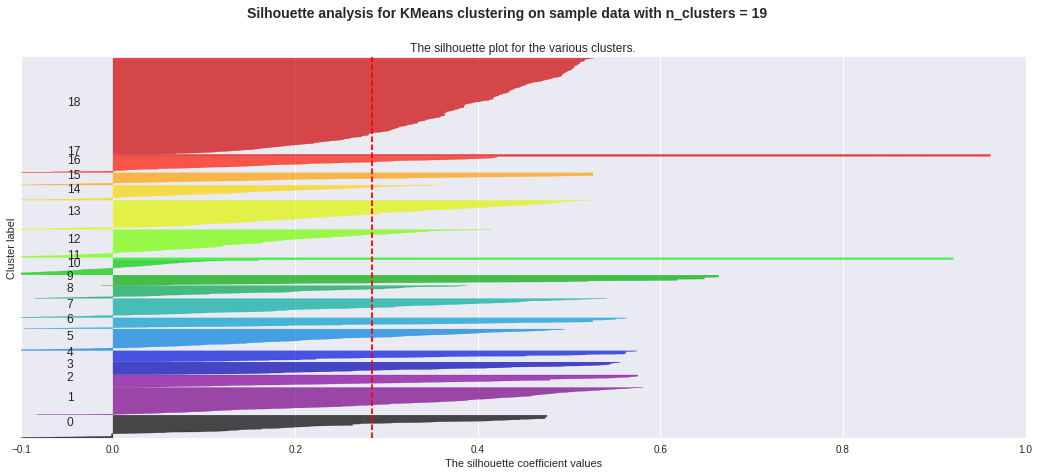

In [118]:
score_this(8,corpus)

### DB Scan Scores

In [87]:
def scan_this(num, df):
    nmf = NMF(n_components=num, #this is dimensions
          init='nndsvd',
          solver = 'cd',
#           random_state=16
         )
    scan = nmf.fit_transform(df)
    print("\n" + 'DIMENSION: %d' % num)
    
    circles = [float(.02), float(.03), float(.04), float(.05)]
    mins = [25, 35, 50, 75]
    for e in circles:
        for s in mins:
            print('eps=%0.3f, min_samples=%0.2f' % (e, s))
            db = DBSCAN(eps=e, min_samples=s).fit(scan)
    
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_
        
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        
            print('Estimated number of clusters: %d' % n_clusters_)
            print("Silhouette Coefficient: %0.3f" 
                  % silhouette_score(scan, labels))

In [88]:
scan_this(8, corpus)
# eps=0.020, min_samples=50.00
# Estimated number of clusters: 10
# Silhouette Coefficient: 0.194


DIMENSION: 8
eps=0.020, min_samples=25.00
Estimated number of clusters: 12
Silhouette Coefficient: -0.009
eps=0.020, min_samples=35.00
Estimated number of clusters: 11
Silhouette Coefficient: 0.152
eps=0.020, min_samples=50.00
Estimated number of clusters: 10
Silhouette Coefficient: 0.201
eps=0.020, min_samples=75.00
Estimated number of clusters: 10
Silhouette Coefficient: 0.151
eps=0.030, min_samples=25.00
Estimated number of clusters: 6
Silhouette Coefficient: 0.138
eps=0.030, min_samples=35.00
Estimated number of clusters: 5
Silhouette Coefficient: 0.250
eps=0.030, min_samples=50.00
Estimated number of clusters: 6
Silhouette Coefficient: 0.151
eps=0.030, min_samples=75.00
Estimated number of clusters: 3
Silhouette Coefficient: 0.248
eps=0.040, min_samples=25.00
Estimated number of clusters: 7
Silhouette Coefficient: 0.107
eps=0.040, min_samples=35.00
Estimated number of clusters: 5
Silhouette Coefficient: 0.144
eps=0.040, min_samples=50.00
Estimated number of clusters: 2
Silhouette

## Cluster IDs
After a few run throughs, 9 clusters appears to be the most common outcome for best silhouette scores for DB Scans & KMeans.

### DB Scan Clusters

In [99]:
db = DBSCAN(eps=0.020, min_samples=50.00)
db.fit(nmf_topic)
db_clusters = db.labels_

In [100]:
np.unique(db_clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

### KMeans Clusters

In [119]:
km = KMeans(n_clusters=9, init='k-means++', n_init=10).fit(nmf_topic) 
km.labels_
km_clusters = km.labels_ 

In [120]:
np.unique(km_clusters)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

# Dataframe it

In [121]:
nho_df['db_id'] = db_clusters
nho_df['km_id'] = km_clusters

In [162]:
pickle.dump(nho_df, open("nho_df.p", "wb"))

In [123]:
nho_df.groupby('db_id').size()

db_id
-1    3302
 0    5629
 1     287
 2     159
 3     158
 4      55
 5      50
 6     342
 7      85
 8     336
dtype: int64

In [124]:
nho_df.groupby('km_id').size()

km_id
0     913
1    3945
2    1136
3     726
4     623
5     620
6    1000
7     463
8     977
dtype: int64

## What's in the clusters?

In [32]:
def see_it(row):
    print(nho_df['overview'][row])
    return nho_df[row:row+1]

In [126]:
for n in range(0,8):
    print('EPITOME OF TOPIC_%d' % n)
    example = nho_df.ix[nho_df['topic_%d' % n].idxmax()]
    print('Index: ', nho_df.index.get_loc(example.name))
    print('KM Cluster:', example['km_id'])
    print('DB Cluster:', example['db_id'])

EPITOME OF TOPIC_0
Index:  107
KM Cluster: 2
DB Cluster: 0
EPITOME OF TOPIC_1
Index:  22
KM Cluster: 5
DB Cluster: 4
EPITOME OF TOPIC_2
Index:  8919
KM Cluster: 8
DB Cluster: 7
EPITOME OF TOPIC_3
Index:  7134
KM Cluster: 3
DB Cluster: -1
EPITOME OF TOPIC_4
Index:  2013
KM Cluster: 6
DB Cluster: -1
EPITOME OF TOPIC_5
Index:  7357
KM Cluster: 0
DB Cluster: -1
EPITOME OF TOPIC_6
Index:  61
KM Cluster: 7
DB Cluster: 5
EPITOME OF TOPIC_7
Index:  34
KM Cluster: 4
DB Cluster: -1


In [134]:
see_it(9712)

Koreatown is in the heart of Los Angeles. It is a bustling neighborhood known for its nightlife, Korean cuisine and karaoke bars, all within walking distance. Just 5 miles west of downtown LA, you have easy access to public transportation that can take you to most major destinations in the city. My home is nestled on a calm street just off the main streets - Olympic Blvd.  There are many restaurants, markets, shopping centers, and nightlife options within a 5-20 minute walk. The Metro Purple Line subway is less than 1 mile from my house. From there you can go all the way east to Union Station in Downtown LA, or connect to other rail lines to Hollywood, Culver City, East LA, Pasadena and Long Beach. There are several local and rapid bus lines within a very short walking distance. (I use public transit exclusively and am happy to assist you if needed.)


,db_id,km_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,overview
9712,3,7,0.009209,0.0,0.005151,0.0,0.006827,0.0,0.106718,0.007982,Koreatown is in the heart of Los Angeles. It i...
